In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf

In [ ]:
tf.version

<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.7/tensorflow_core/_api/v1/version/__init__.py'>

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15009864948670003178, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14514009065167403199
 physical_device_desc: "device: XLA_CPU device"]

In [ ]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:         4920024 kB
MemAvailable:   12065164 kB
Buffers:          156492 kB
Cached:          6968456 kB
SwapCached:            0 kB
Active:          1550724 kB
Inactive:        6480844 kB
Active(anon):     800172 kB
Inactive(anon):      460 kB
Active(file):     750552 kB
Inactive(file):  6480384 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               540 kB
Writeback:             0 kB
AnonPages:        906800 kB
Mapped:           340780 kB
Shmem:              1188 kB
KReclaimable:     240152 kB
Slab:             283404 kB
SReclaimable:     240152 kB
SUnreclaim:        43252 kB
KernelStack:        4992 kB
PageTables:        11788 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    3311060 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        7328 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
#Import packages
import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
import tensorflow as tf
import numpy as np
import re
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
%load_ext tensorboard

**Data preprocessing**

This is the one of the important things while creating a chatbot. Here we will do some preprocessing on the dataset.

1. After importing the dataset, we will get the converastion lines and movie lines and convert it into list of questions and anwers.

2. We will take every sentence and lower it and clean every sentence of questions and anwers by converting words like i'm to i am.

3. We will filter the sentences that are too long or short.

4. We will add End of string (EOS) and Start of string (SOS) to every sentence and convert every word to word2vec.

In [ ]:
#get the conversation and movie data
movie_line = "movie_lines.txt"
movie_convo = "movie_conversations.txt"

m_lines = open(movie_line , encoding='utf-8',errors='ignore').read().split('\n')
c_lines = open(movie_convo , encoding='utf-8',errors='ignore').read().split('\n')

#get converastion lines
convo_line = []
for lines in c_lines:
    _lines = lines.split(" +++$+++ ")[-1][1:-1].replace("'","").replace(" ","")
    convo_line.append(_lines.split(","))

#get movie lines
id_line = {}
for lines in m_lines:
    _lines = lines.split(" +++$+++ ")
    if len(_lines) == 5:
        id_line[_lines[0]] = _lines[4]
        
#Form questions and answers 
questions = []
answers = []

for line in convo_line:
    for i in range(len(line) -1):
        questions.append(id_line[line[i]])
        answers.append(id_line[line[i+1]])
        
#Clean and replace improper words using regular expression
def clean_text(text):
    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"  ","",text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

clean_questions = []
clean_answers = []

for q in questions:
    clean_questions.append(clean_text(q))
for a in answers:
    clean_answers.append(clean_text(a))
    
#get the min and max length of sentence need to be used
max_length = 5
min_length = 2

codes = ['<PAD>','<EOS>','<UNK>','<GO>']



short_questions_temp = []
short_answers_temp = []

i = 0
for question in clean_questions:
    if len(question.split()) >= min_length and len(question.split()) <= max_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])
    i += 1

# Filter out the answers that are too short/long
shorted_q = []
shorted_a = []

i = 0
for answer in short_answers_temp:
    if len(answer.split()) >= min_length and len(answer.split()) <= max_length:
        shorted_a.append(answer)
        shorted_q.append(short_questions_temp[i])
    i += 1
   
  

#Get the count of words from filtered questions and answers  
vocab = {}

for question in shorted_q:
    for words in question.split():
        if words not in vocab:
            vocab[words] = 1
        else:
            vocab[words] +=1
for answer in shorted_a:
    for words in answer.split():
        if words not in vocab:
            vocab[words] = 1
        else:
            vocab[words] +=1
            
questions_vocabs = {}
for answer in shorted_q:
    for words in answer.split():
        if words not in questions_vocabs:
            questions_vocabs[words] = 1
        else:
            questions_vocabs[words] +=1
            
answers_vocabs = {}
for answer in shorted_a:
    for words in answer.split():
        if words not in answers_vocabs:
            answers_vocabs[words] = 1
        else:
            answers_vocabs[words] +=1
            
#total number of words appear more than 2 times
vocabs_to_index = {}
threshold = 2
word_num = 0
for word, count in vocab.items():
    if count >= threshold:
        vocabs_to_index[word] = word_num
        word_num += 1

#add words in codes in the text and  increment vocab index to 1 for each existing code 
#same for question and answer vocab.6281 in vocab dict and now 6286        
for code in codes:
    vocabs_to_index[code] = len(vocabs_to_index)+1
    
for code in codes:
    questions_vocabs[code] = len(questions_vocabs)+1

for code in codes:
    answers_vocabs[code] = len(answers_vocabs)+1

#Convert index vocab to vocab index   
index_to_vocabs = {v_i: v for v, v_i in vocabs_to_index.items()}

#Add <EOS> to the end of all the answer in such a way model can learn the the sentence comes to the end 
for i in range(len(shorted_a)):
  shorted_a[i] += ' <EOS>'
  
#Get the question and with code <UNK> for the words which are not in vocab to index
#ex:'nowhere hi daddy <EOS> ' to '[6285, 179, 22, 6284]' as it doesnt find the word 'nowhere' in the vocabulary index dictionary

questions_int = []
for question in shorted_q:
    ints = []
    for word in question.split():
        if word not in vocabs_to_index:
            ints.append(vocabs_to_index['<UNK>'])
        else:
            ints.append(vocabs_to_index[word])
    questions_int.append(ints)
    
answers_int = []
for answer in shorted_a:
    ints = []
    for word in answer.split():
        if word not in vocabs_to_index:
            ints.append(vocabs_to_index['<UNK>'])
        else:
            ints.append(vocabs_to_index[word])
    answers_int.append(ints)

In [ ]:
for code in codes:
  print(vocabs_to_index[code])

6283
6284
6285
6286


**Parameters**

This are the parameters and we can you this as hyperparameters too.
Due to computational power, I am using it as a default parameters 


In [ ]:
target_vocab_size = len(answers_vocabs)
source_vocab_size = len(questions_vocabs)
vocab_size = len(index_to_vocabs)+1
embed_size = 512
rnn_size = 512
batch_size = 512
#num_layers =  3
learning_rate = 0.001
learning_rate_decay = 0.99
min_lr = 0.0001
#keep_prob = 0.5
epochs= 2
DISPLAY_STEP=30


**LSTM**

Reference: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.


All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

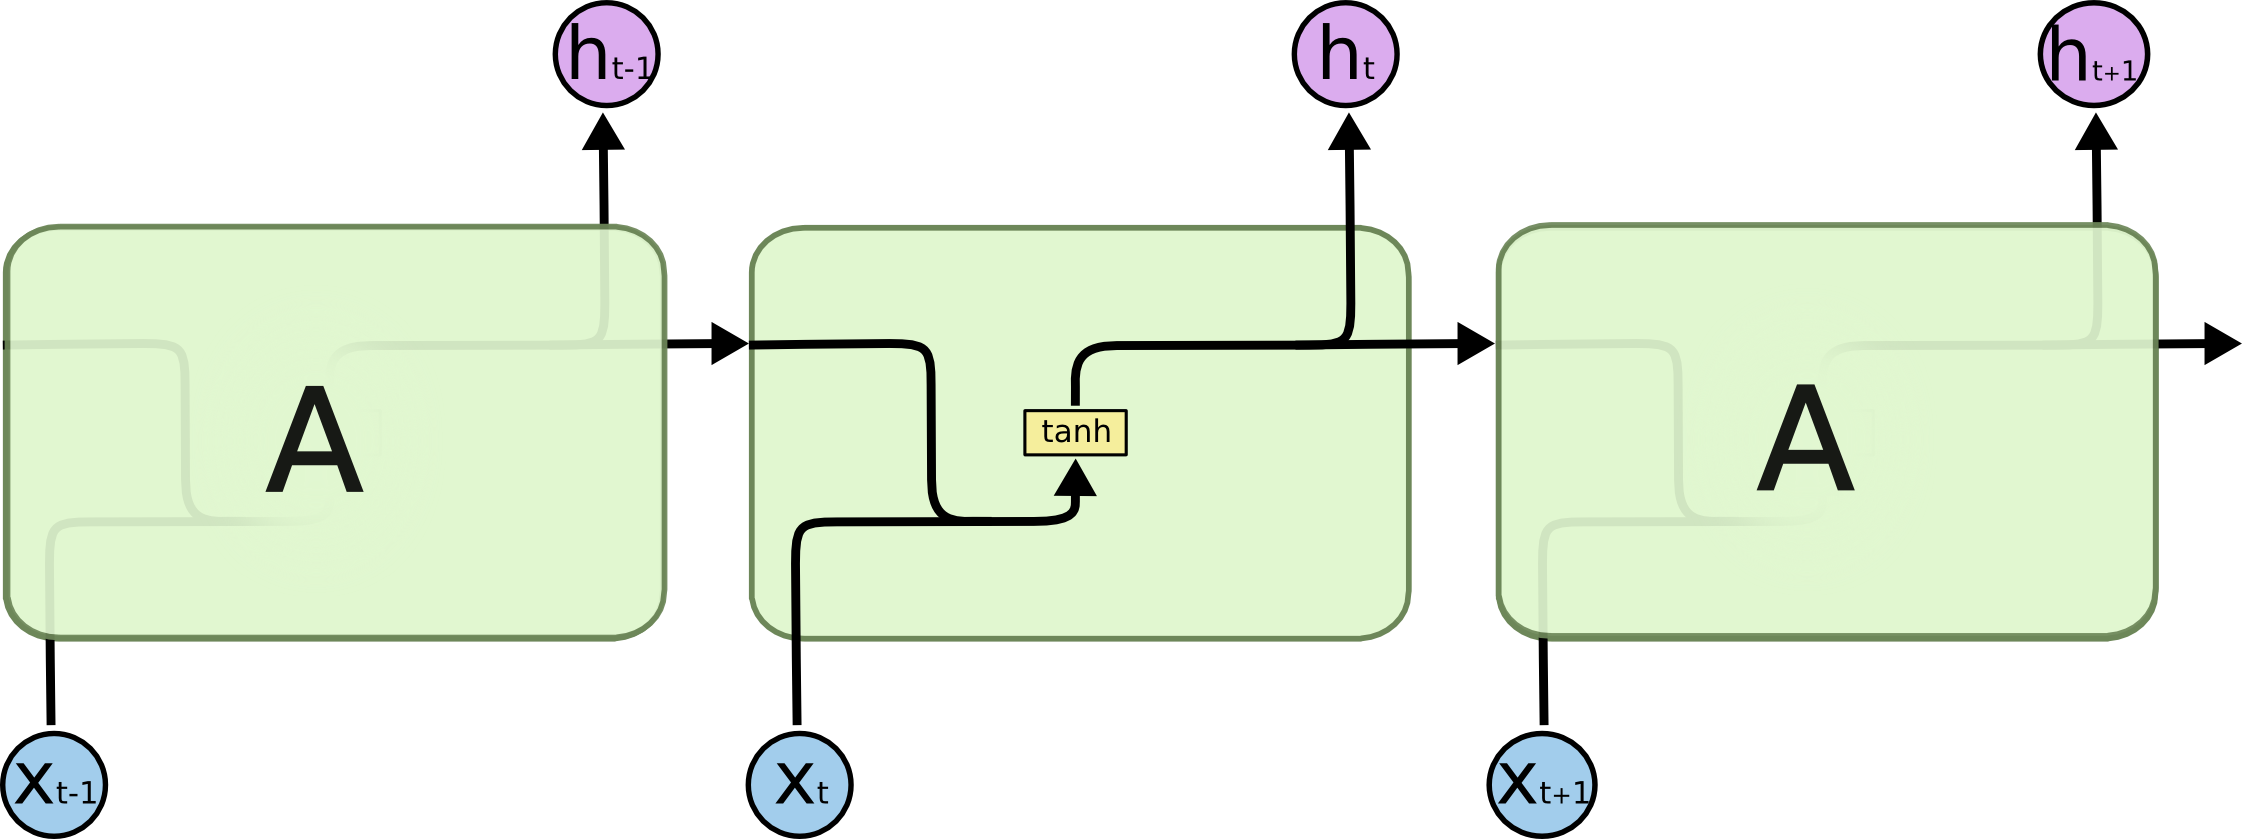



In [ ]:
def lstm(rnn_size, keep_prob,reuse=False):
    lstm =tf.nn.rnn_cell.LSTMCell(rnn_size,reuse=reuse)
    drop =tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    return drop

In [ ]:
def attention(rnn_size,encoder_outputs,target_sequence_length,dec_cell):
    attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size*2,encoder_outputs,
                                                                   memory_sequence_length=target_sequence_length)
    attention_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attention_mechanism,
                                                             attention_layer_size=rnn_size/2)
    return attention_cell

In [ ]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#tf.disable_eager_execution()

# Creating a placeholders in tensorflow

In [ ]:
input_data = tf.placeholder(tf.int32, [None, None],name='input')
target_data = tf.placeholder(tf.int32, [None, None],name='target')
input_data_len = tf.placeholder(tf.int32,[None],name='input_len')
target_data_len = tf.placeholder(tf.int32,[None],name='target_len')
lr_rate = tf.placeholder(tf.float32,name='lr')
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

In [ ]:
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size, embed_size], -1, 1))
encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, input_data)

In [ ]:
stacked_cells = lstm(rnn_size, keep_prob)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [ ]:
((encoder_fw_outputs,encoder_bw_outputs),
 (encoder_fw_final_state,encoder_bw_final_state)) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked_cells, 
                                                                 cell_bw=stacked_cells, 
                                                                 inputs=encoder_embedded, 
                                                                 sequence_length=input_data_len, 
                                                                 dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


An RNN Encoder–Decoder, consists of two recurrent neural networks (RNN) that act as an encoder and a decoder pair. The encoder maps a variable-length source sequence to a fixed-length vector, and the decoder maps the vector representation back to a variable-length target sequence.


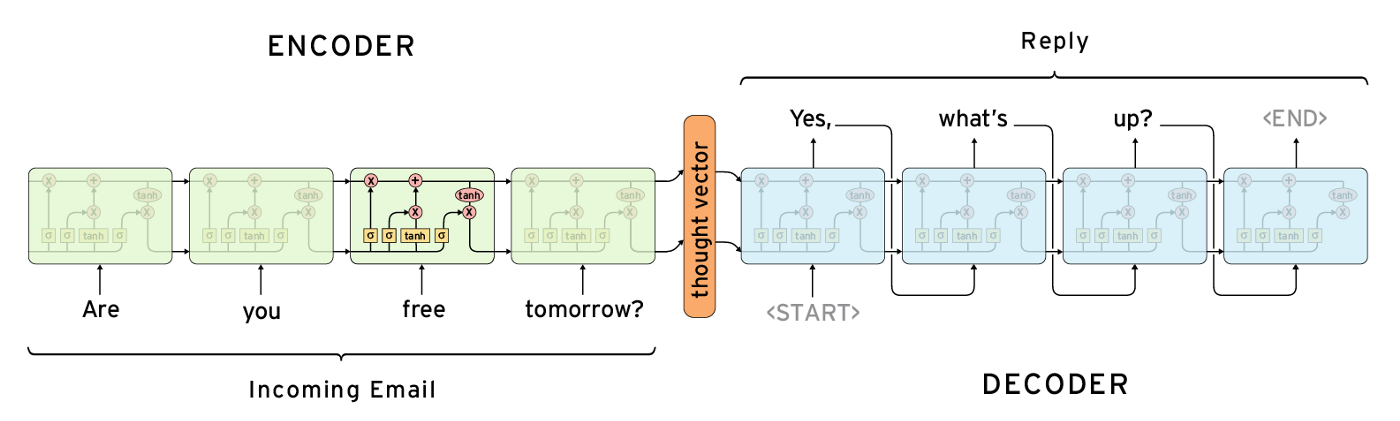



In [ ]:
encoder_outputs = tf.concat((encoder_fw_outputs,encoder_bw_outputs),2)

In [ ]:
encoder_outputs

<tf.Tensor 'concat:0' shape=(?, ?, 1024) dtype=float32>

In [ ]:
encoder_state_c = tf.concat((encoder_fw_final_state.c,encoder_bw_final_state.c),1)
encoder_state_h = tf.concat((encoder_fw_final_state.h,encoder_bw_final_state.h),1)
encoder_states = tf.nn.rnn_cell.LSTMStateTuple(c=encoder_state_c,h=encoder_state_h)

In [ ]:
encoder_states

LSTMStateTuple(c=<tf.Tensor 'concat_1:0' shape=(?, 1024) dtype=float32>, h=<tf.Tensor 'concat_2:0' shape=(?, 1024) dtype=float32>)

In [ ]:
main = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
decoder_input = tf.concat([tf.fill([batch_size, 1],vocabs_to_index['<GO>']), main], 1)

In [ ]:
#same process as followed in encoder embedding and lookups
decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, embed_size], -1, 1))
dec_cell_inputs = tf.nn.embedding_lookup(decoder_embeddings, decoder_input)

In [ ]:
dec_cell = lstm(rnn_size*2,keep_prob)

In [ ]:
dec_cell

In [ ]:
#output layer for decoder
dense_layer = tf.layers.Dense(target_vocab_size)

In [ ]:
#!pip install tensorflow_addons


In [ ]:
tf.version

<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.7/tensorflow_core/_api/v1/version/__init__.py'>

In [ ]:
#import tensorflow.compat.v1 as tf 
#tf.disable_v2_behavior()

In [ ]:
train_helper = tf.contrib.seq2seq.TrainingHelper(dec_cell_inputs, target_data_len)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
attention_cell = attention(rnn_size,encoder_outputs,target_data_len,dec_cell)
state = attention_cell.zero_state(dtype=tf.float32, batch_size=batch_size)
state = state.clone(cell_state=encoder_states)

In [ ]:
decoder_train = tf.contrib.seq2seq.BasicDecoder(cell=attention_cell, helper=train_helper, 
                                                  initial_state=state,
                                                  output_layer=dense_layer) 

In [ ]:
outputs_train, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder_train, 
                                                  impute_finished=True, 
                                                  maximum_iterations=tf.reduce_max(target_data_len))

In [ ]:
infer_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings, 
                                                          tf.fill([batch_size], vocabs_to_index['<GO>']), 
                                                          vocabs_to_index['<EOS>'])

In [ ]:
decoder_infer = tf.contrib.seq2seq.BasicDecoder(cell=attention_cell, helper=infer_helper, 
                                                  initial_state=state,
                                                  output_layer=dense_layer)

In [ ]:
outputs_infer, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder_infer, impute_finished=True,
                                                          maximum_iterations=tf.reduce_max(target_data_len))

In [ ]:
training_logits = tf.identity(outputs_train.rnn_output, name='logits')
inference_logits = tf.identity(outputs_infer.sample_id, name='predictions')

In [ ]:
masks = tf.sequence_mask(target_data_len, tf.reduce_max(target_data_len), dtype=tf.float32, name='masks')

In [ ]:
cost = tf.contrib.seq2seq.sequence_loss(training_logits,target_data,masks)

**Adam Optimizer**

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [ ]:
optimizer = tf.train.AdamOptimizer(lr_rate)

**Gradient Clipping**

Training recurrent neural networks can be very difficult. Two common issues with training recurrent neural networks are vanishing gradients and exploding gradients. Exploding gradients can occur when the gradient becomes too large and error gradients accumulate, resulting in an unstable network. Vanishing gradients can happen when optimization gets stuck at a certain point because the gradient is too small to progress. Gradient clipping can prevent these issues in the gradients that mess up the parameters during training

In [ ]:
gradients = optimizer.compute_gradients(cost)
capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
train_op = optimizer.apply_gradients(capped_gradients)

In [ ]:
def pad_sentence(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(len(sentence))
    return padded_seqs, seq_lens

In [ ]:
def get_accuracy(target, logits):
    max_seq = max(len(target[1]), logits.shape[1])
    if max_seq - len(target[1]):
        target = np.pad(
            target,
            [(0,0),(0,max_seq - len(target[1]))],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

In [ ]:
train_data = questions_int[batch_size:]
test_data = answers_int[batch_size:]
val_train_data = questions_int[:batch_size]
val_test_data = answers_int[:batch_size]

In [ ]:
len(train_data)

22608

In [ ]:
pad_int = vocabs_to_index['<PAD>']

In [ ]:
val_batch_x,val_batch_len = pad_sentence(val_train_data,pad_int)
val_batch_y,val_batch_len_y = pad_sentence(val_test_data,pad_int)
val_batch_x = np.array(val_batch_x)
val_batch_y = np.array(val_batch_y)

In [ ]:
no_of_batches = math.floor(len(train_data)//batch_size)
round_no = no_of_batches*batch_size

In [ ]:
def sentence_to_seq(sentence, vocabs_to_index):
    results = []
    for word in sentence.split(" "):
        if word in vocabs_to_index:
            results.append(vocabs_to_index[word])
        else:
            results.append(vocabs_to_index['<UNK>'])        
    return results

In [ ]:
question_sentence = 'where are you'
question_sentence = sentence_to_seq(question_sentence, vocabs_to_index)
print(question_sentence)

[10, 14, 12]


In [ ]:
file_writer = tf.summary.FileWriter('/content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/log')

In [ ]:
summaries_op = tf.summary.merge_all()

In [ ]:
#save_path = 'model_weights'

In [ ]:
save_path = '/content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/model_weights'

acc_plt = []
loss_plt = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        #_, summaries_str = sess.run([train_op, summaries_op])
        #fw.add_summary(summaries_str, global_step=i)
        total_accuracy = 0.0
        total_loss = 0.0
        for bs in tqdm(range(0,round_no  ,batch_size)):
          index = min(bs+batch_size, round_no )
          #print(bs,index)
      
          #padding done seperately for each batch in training and testing data
          batch_x,len_x = pad_sentence(train_data[bs:index],pad_int)
          batch_y,len_y = pad_sentence(test_data[bs:index],pad_int)
          batch_x = np.array(batch_x)
          batch_y = np.array(batch_y)
        
          pred,loss_f,opt = sess.run([inference_logits,cost,train_op], 
                                      feed_dict={input_data:batch_x,
                                                target_data:batch_y,
                                                input_data_len:len_x,
                                                target_data_len:len_y,
                                                lr_rate:learning_rate,
                                                keep_prob:0.75})

          train_acc = get_accuracy(batch_y, pred)
          total_loss += loss_f 
          total_accuracy+=train_acc
    
        total_accuracy /= (round_no // batch_size)
    
        total_loss /=  (round_no//batch_size)
        acc_plt.append(total_accuracy)
        loss_plt.append(total_loss)
        prediction_logits = sess.run(inference_logits, {input_data: [question_sentence]*batch_size,
                                         input_data_len: [len(question_sentence)]*batch_size,
                                         target_data_len: [len(question_sentence)]*batch_size,              
                                         keep_prob: 0.75,
                                         })[0]
        print('Epoch %d,Average_loss %f, Average Accucracy %f'%(epoch+1,total_loss,total_accuracy))
        print('  Inputs Words: {}'.format([index_to_vocabs[i] for i in question_sentence]))
        print('  Replied Words: {}'.format(" ".join([index_to_vocabs[i] for i in prediction_logits])))
        print('\n')
        saver = tf.train.Saver() 
        saver.save(sess, save_path)
    

100%|██████████| 44/44 [05:26<00:00,  7.41s/it]


Epoch 1,Average_loss 5.523310, Average Accucracy 0.035800
  Inputs Words: ['where', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 44/44 [05:07<00:00,  7.00s/it]


Epoch 2,Average_loss 4.636299, Average Accucracy 0.081935
  Inputs Words: ['where', 'are', 'you']
  Replied Words: i am <EOS>




In [ ]:
%tensorboard --logdir /content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL] [--db URI]
                   [--db_import] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   [--whatif-data-dir PATH]
tensorboard: error: unrecognized ar

In [ ]:
#get all the codes/tokens we additionaly added in the vocab dictionary
garbage = []
for code in codes:
  print(vocabs_to_index[code])
  garbage.append(vocabs_to_index[code])

6283
6284
6285
6286


In [ ]:
#prepare the question,answer and prediction data
def print_data(i,batch_x,index_to_vocabs):
  data = []
  for n in batch_x[i]:
    if n==garbage[1]:
      break
    else:
      if n not in [6283,6285,6286]:
        data.append(index_to_vocabs[n])
  return data

In [ ]:
ques = []
real_answer = []
pred_answer = []
for i in range(len(val_batch_x)):
  ques.append(print_data(i,batch_x,index_to_vocabs))
  real_answer.append(print_data(i,batch_y,index_to_vocabs))
  pred_answer.append(print_data(i,pred,index_to_vocabs))

In [ ]:
for i in range(len(val_batch_x)):
    print('row %d'%(i+1))
    print('QUESTION:',' '.join(ques[i]))
    print('REAL ANSWER:',' '.join(real_answer[i]))
    print('PREDICTED ANSWER:',' '.join(pred_answer[i]),'\n')

row 1
QUESTION: where did you get that
REAL ANSWER: at the on
PREDICTED ANSWER: i do not know 

row 2
QUESTION: did she believe you
REAL ANSWER: i have no idea
PREDICTED ANSWER: i have to see you 

row 3
QUESTION: where is boyd
REAL ANSWER: downstairs in the closet
PREDICTED ANSWER: in the front 

row 4
QUESTION: what song
REAL ANSWER: you send me
PREDICTED ANSWER: you are not a 

row 5
QUESTION: the stone age
REAL ANSWER: the postvegas man
PREDICTED ANSWER: the 

row 6
QUESTION: the postvegas man
REAL ANSWER: a mutant species
PREDICTED ANSWER: the 

row 7
QUESTION: a mutant species
REAL ANSWER: okay boys smile
PREDICTED ANSWER: no thanks i was 

row 8
QUESTION: good times
REAL ANSWER: real times
PREDICTED ANSWER: you are not a professional 

row 9
QUESTION: she is dead
REAL ANSWER: it was an accident
PREDICTED ANSWER: she is not a cat 

row 10
QUESTION: shut up micheal
REAL ANSWER: i killed my brother
PREDICTED ANSWER: i am a 

row 11
QUESTION: don
REAL ANSWER: that is that
PREDICTED 

In [ ]:
question_sentence_2 = 'what are you doing?'
question_sentence_2 = sentence_to_seq(question_sentence_2, vocabs_to_index)
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(save_path + '.meta')
    loader.restore(sess, save_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    input_data_len = loaded_graph.get_tensor_by_name('input_len:0')
    target_data_len = loaded_graph.get_tensor_by_name('target_len:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    prediction_logits = sess.run(logits, {input_data: [question_sentence_2]*batch_size,
                                         input_data_len: [len(question_sentence_2)]*batch_size,
                                         target_data_len : [5]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in question_sentence_2]))
print('  Question: {}'.format([index_to_vocabs[i] for i in question_sentence_2]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in prediction_logits]))
print('  Answer: {}'.format(" ".join([index_to_vocabs[i] for i in prediction_logits])))


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/model_weights
Input
  Word Ids:      [0, 14, 12, 6285]
  Question: ['what', 'are', 'you', '<UNK>']

Prediction
  Word Ids:      [6285, 6285, 6285, 6284]
  Answer: <UNK> <UNK> <UNK> <EOS>


In [ ]:
for i in range(10):
  question_sentence_2 = input(str())
  if question_sentence_2 != "Bye":
    question_sentence_2 = sentence_to_seq(question_sentence_2, vocabs_to_index)
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
      # Load saved model
      loader = tf.train.import_meta_graph(save_path + '.meta')
      loader.restore(sess, save_path)

      input_data = loaded_graph.get_tensor_by_name('input:0')
      logits = loaded_graph.get_tensor_by_name('predictions:0')
      input_data_len = loaded_graph.get_tensor_by_name('input_len:0')
      target_data_len = loaded_graph.get_tensor_by_name('target_len:0')
      keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

      prediction_logits = sess.run(logits, {input_data: [question_sentence_2]*batch_size,
                                           input_data_len: [len(question_sentence_2)]*batch_size,
                                           target_data_len : [5]*batch_size,
                                           keep_prob: 1.0})[0]

    
    print('  Word Ids:      {}'.format([i for i in question_sentence_2]))
    print('  Question: {}'.format([index_to_vocabs[i] for i in question_sentence_2]))

    print('\nPrediction')
    print('  Word Ids:      {}'.format([i for i in prediction_logits]))
    print('  Answer: {}'.format(" ".join([index_to_vocabs[i] for i in prediction_logits])))

  else:
    print("Bye")

hi
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/model_weights
  Word Ids:      [179]
  Question: ['hi']

Prediction
  Word Ids:      [23, 108, 6284]
  Answer: i am <EOS>
who are you
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/model_weights
  Word Ids:      [145, 14, 12]
  Question: ['who', 'are', 'you']

Prediction
  Word Ids:      [23, 108, 6284]
  Answer: i am <EOS>
h
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/model_weights
  Word Ids:      [1320]
  Question: ['h']

Prediction
  Word Ids:      [23, 108, 6284]
  Answer: i am <EOS>
ok
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/ML Projects/Global IA/Seq2Seq-Chatbot/Notebook/model_weights/model_weights
  Word Ids:      [1071]
  Question: ['ok']

Prediction
  Word Ids:   

**Observations**

1. Here, we did not get good accuracy beacuse of less number of epoch. However if we increase the number of epoch, the accuracy with increase exponentially.

2. Attetion mechanism is necessary because seq2seq alone can't predict perfectly